# Deep Learning: Laparoscopic segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 5e-4
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

CLASS_WEIGHTS = [2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03]

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

c:\Users\alexg\miniconda3\envs\pytorch-gpu\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.DiceLoss(class_weights=CLASS_WEIGHTS).cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = math.ceil(len(trainDS) / BATCH_SIZE)
testSteps = math.ceil(len(testDS) / BATCH_SIZE)
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
bestIoU = 0
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

	if avgTestIoU > bestIoU:
		bestIoU = avgTestIoU
		torch.save(uformer.state_dict(), '../models/uformer_diceLoss.pth')
		print('Best IoU improved. Model saved.')
		
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')

[INFO] training the network...


100%|██████████| 144/144 [01:57<00:00,  1.22it/s]


[INFO] EPOCH: 1/100
Train loss: 0.964135, Test loss: 0.9549, Train IoU: 0.3582, Test IoU: 0.4600, Train Dice: 0.5091, Test Dice: 0.6279
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


[INFO] EPOCH: 2/100
Train loss: 0.950974, Test loss: 0.9489, Train IoU: 0.5117, Test IoU: 0.5447, Train Dice: 0.6749, Test Dice: 0.7035
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 3/100
Train loss: 0.946124, Test loss: 0.9434, Train IoU: 0.5997, Test IoU: 0.6414, Train Dice: 0.7463, Test Dice: 0.7769
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 4/100
Train loss: 0.940954, Test loss: 0.9385, Train IoU: 0.6795, Test IoU: 0.7216, Train Dice: 0.8041, Test Dice: 0.8336
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:55<00:00,  1.24it/s]


[INFO] EPOCH: 5/100
Train loss: 0.937826, Test loss: 0.9369, Train IoU: 0.7307, Test IoU: 0.7431, Train Dice: 0.8394, Test Dice: 0.8483
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:56<00:00,  1.23it/s]


[INFO] EPOCH: 6/100
Train loss: 0.936522, Test loss: 0.9356, Train IoU: 0.7516, Test IoU: 0.7654, Train Dice: 0.8539, Test Dice: 0.8625
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:46<00:00,  1.36it/s]


[INFO] EPOCH: 7/100
Train loss: 0.934841, Test loss: 0.9333, Train IoU: 0.7770, Test IoU: 0.8061, Train Dice: 0.8699, Test Dice: 0.8892
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:41<00:00,  1.41it/s]


[INFO] EPOCH: 8/100
Train loss: 0.933269, Test loss: 0.9327, Train IoU: 0.8054, Test IoU: 0.8182, Train Dice: 0.8889, Test Dice: 0.8972
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:46<00:00,  1.35it/s]


[INFO] EPOCH: 9/100
Train loss: 0.932460, Test loss: 0.9320, Train IoU: 0.8199, Test IoU: 0.8302, Train Dice: 0.8983, Test Dice: 0.9046
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:45<00:00,  1.36it/s]


[INFO] EPOCH: 10/100
Train loss: 0.931865, Test loss: 0.9315, Train IoU: 0.8314, Test IoU: 0.8395, Train Dice: 0.9054, Test Dice: 0.9103
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:45<00:00,  1.36it/s]


[INFO] EPOCH: 11/100
Train loss: 0.931411, Test loss: 0.9311, Train IoU: 0.8395, Test IoU: 0.8473, Train Dice: 0.9103, Test Dice: 0.9152
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 12/100
Train loss: 0.931134, Test loss: 0.9309, Train IoU: 0.8452, Test IoU: 0.8498, Train Dice: 0.9137, Test Dice: 0.9165
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


[INFO] EPOCH: 13/100
Train loss: 0.930936, Test loss: 0.9308, Train IoU: 0.8489, Test IoU: 0.8542, Train Dice: 0.9160, Test Dice: 0.9195
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:46<00:00,  1.35it/s]


[INFO] EPOCH: 14/100
Train loss: 0.930722, Test loss: 0.9304, Train IoU: 0.8527, Test IoU: 0.8606, Train Dice: 0.9183, Test Dice: 0.9231
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:46<00:00,  1.36it/s]


[INFO] EPOCH: 15/100
Train loss: 0.930500, Test loss: 0.9303, Train IoU: 0.8573, Test IoU: 0.8603, Train Dice: 0.9210, Test Dice: 0.9229


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 16/100
Train loss: 0.930360, Test loss: 0.9302, Train IoU: 0.8598, Test IoU: 0.8653, Train Dice: 0.9226, Test Dice: 0.9260
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:43<00:00,  1.39it/s]


[INFO] EPOCH: 17/100
Train loss: 0.930173, Test loss: 0.9300, Train IoU: 0.8633, Test IoU: 0.8680, Train Dice: 0.9247, Test Dice: 0.9274
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:48<00:00,  1.33it/s]


[INFO] EPOCH: 18/100
Train loss: 0.930065, Test loss: 0.9299, Train IoU: 0.8655, Test IoU: 0.8696, Train Dice: 0.9259, Test Dice: 0.9284
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:46<00:00,  1.36it/s]


[INFO] EPOCH: 19/100
Train loss: 0.929937, Test loss: 0.9298, Train IoU: 0.8674, Test IoU: 0.8700, Train Dice: 0.9271, Test Dice: 0.9287
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:43<00:00,  1.39it/s]


[INFO] EPOCH: 20/100
Train loss: 0.929835, Test loss: 0.9298, Train IoU: 0.8694, Test IoU: 0.8704, Train Dice: 0.9283, Test Dice: 0.9289
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


[INFO] EPOCH: 21/100
Train loss: 0.929730, Test loss: 0.9296, Train IoU: 0.8713, Test IoU: 0.8750, Train Dice: 0.9294, Test Dice: 0.9316
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:45<00:00,  1.36it/s]


[INFO] EPOCH: 22/100
Train loss: 0.929629, Test loss: 0.9295, Train IoU: 0.8732, Test IoU: 0.8777, Train Dice: 0.9305, Test Dice: 0.9333
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:44<00:00,  1.38it/s]


[INFO] EPOCH: 23/100
Train loss: 0.929544, Test loss: 0.9295, Train IoU: 0.8747, Test IoU: 0.8752, Train Dice: 0.9314, Test Dice: 0.9317


100%|██████████| 144/144 [01:45<00:00,  1.37it/s]


[INFO] EPOCH: 24/100
Train loss: 0.929440, Test loss: 0.9294, Train IoU: 0.8766, Test IoU: 0.8772, Train Dice: 0.9325, Test Dice: 0.9329


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 25/100
Train loss: 0.929391, Test loss: 0.9292, Train IoU: 0.8774, Test IoU: 0.8815, Train Dice: 0.9330, Test Dice: 0.9354
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.29it/s]


[INFO] EPOCH: 26/100
Train loss: 0.929343, Test loss: 0.9293, Train IoU: 0.8782, Test IoU: 0.8792, Train Dice: 0.9335, Test Dice: 0.9342


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 27/100
Train loss: 0.929244, Test loss: 0.9291, Train IoU: 0.8802, Test IoU: 0.8815, Train Dice: 0.9347, Test Dice: 0.9355
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 28/100
Train loss: 0.929123, Test loss: 0.9290, Train IoU: 0.8818, Test IoU: 0.8839, Train Dice: 0.9356, Test Dice: 0.9368
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 29/100
Train loss: 0.929025, Test loss: 0.9289, Train IoU: 0.8840, Test IoU: 0.8866, Train Dice: 0.9368, Test Dice: 0.9385
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 30/100
Train loss: 0.928915, Test loss: 0.9289, Train IoU: 0.8857, Test IoU: 0.8861, Train Dice: 0.9378, Test Dice: 0.9380


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 31/100
Train loss: 0.928880, Test loss: 0.9288, Train IoU: 0.8867, Test IoU: 0.8885, Train Dice: 0.9384, Test Dice: 0.9395
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 32/100
Train loss: 0.928755, Test loss: 0.9286, Train IoU: 0.8892, Test IoU: 0.8920, Train Dice: 0.9399, Test Dice: 0.9414
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 33/100
Train loss: 0.928716, Test loss: 0.9287, Train IoU: 0.8895, Test IoU: 0.8899, Train Dice: 0.9400, Test Dice: 0.9404


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 34/100
Train loss: 0.928707, Test loss: 0.9285, Train IoU: 0.8897, Test IoU: 0.8937, Train Dice: 0.9402, Test Dice: 0.9426
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 35/100
Train loss: 0.928574, Test loss: 0.9286, Train IoU: 0.8928, Test IoU: 0.8918, Train Dice: 0.9419, Test Dice: 0.9415


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 36/100
Train loss: 0.928554, Test loss: 0.9285, Train IoU: 0.8927, Test IoU: 0.8949, Train Dice: 0.9419, Test Dice: 0.9433
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 37/100
Train loss: 0.928481, Test loss: 0.9285, Train IoU: 0.8943, Test IoU: 0.8951, Train Dice: 0.9429, Test Dice: 0.9434
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 38/100
Train loss: 0.928394, Test loss: 0.9284, Train IoU: 0.8961, Test IoU: 0.8971, Train Dice: 0.9439, Test Dice: 0.9445
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 39/100
Train loss: 0.928390, Test loss: 0.9284, Train IoU: 0.8960, Test IoU: 0.8975, Train Dice: 0.9438, Test Dice: 0.9448
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 40/100
Train loss: 0.928375, Test loss: 0.9283, Train IoU: 0.8967, Test IoU: 0.8981, Train Dice: 0.9443, Test Dice: 0.9451
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 41/100
Train loss: 0.928229, Test loss: 0.9283, Train IoU: 0.8993, Test IoU: 0.8976, Train Dice: 0.9458, Test Dice: 0.9448


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 42/100
Train loss: 0.928232, Test loss: 0.9283, Train IoU: 0.8994, Test IoU: 0.8991, Train Dice: 0.9458, Test Dice: 0.9456
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 43/100
Train loss: 0.928222, Test loss: 0.9283, Train IoU: 0.8993, Test IoU: 0.8992, Train Dice: 0.9458, Test Dice: 0.9458
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 44/100
Train loss: 0.928204, Test loss: 0.9283, Train IoU: 0.9001, Test IoU: 0.8974, Train Dice: 0.9463, Test Dice: 0.9448


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 45/100
Train loss: 0.928141, Test loss: 0.9282, Train IoU: 0.9013, Test IoU: 0.9001, Train Dice: 0.9470, Test Dice: 0.9463
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:53<00:00,  1.26it/s]


[INFO] EPOCH: 46/100
Train loss: 0.928069, Test loss: 0.9281, Train IoU: 0.9025, Test IoU: 0.9024, Train Dice: 0.9477, Test Dice: 0.9477
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 47/100
Train loss: 0.928036, Test loss: 0.9280, Train IoU: 0.9031, Test IoU: 0.9041, Train Dice: 0.9480, Test Dice: 0.9486
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 48/100
Train loss: 0.928067, Test loss: 0.9283, Train IoU: 0.9025, Test IoU: 0.8989, Train Dice: 0.9477, Test Dice: 0.9457


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 49/100
Train loss: 0.927990, Test loss: 0.9280, Train IoU: 0.9043, Test IoU: 0.9036, Train Dice: 0.9487, Test Dice: 0.9484


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 50/100
Train loss: 0.927964, Test loss: 0.9280, Train IoU: 0.9047, Test IoU: 0.9055, Train Dice: 0.9489, Test Dice: 0.9494
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 51/100
Train loss: 0.927891, Test loss: 0.9280, Train IoU: 0.9062, Test IoU: 0.9052, Train Dice: 0.9498, Test Dice: 0.9493


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 52/100
Train loss: 0.927924, Test loss: 0.9279, Train IoU: 0.9057, Test IoU: 0.9055, Train Dice: 0.9495, Test Dice: 0.9495
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 53/100
Train loss: 0.927882, Test loss: 0.9280, Train IoU: 0.9064, Test IoU: 0.9054, Train Dice: 0.9499, Test Dice: 0.9495


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 54/100
Train loss: 0.927891, Test loss: 0.9279, Train IoU: 0.9066, Test IoU: 0.9070, Train Dice: 0.9501, Test Dice: 0.9503
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 55/100
Train loss: 0.927829, Test loss: 0.9278, Train IoU: 0.9073, Test IoU: 0.9083, Train Dice: 0.9504, Test Dice: 0.9511
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 56/100
Train loss: 0.927819, Test loss: 0.9278, Train IoU: 0.9076, Test IoU: 0.9072, Train Dice: 0.9506, Test Dice: 0.9505


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 57/100
Train loss: 0.927742, Test loss: 0.9278, Train IoU: 0.9092, Test IoU: 0.9085, Train Dice: 0.9515, Test Dice: 0.9512
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 58/100
Train loss: 0.927781, Test loss: 0.9278, Train IoU: 0.9086, Test IoU: 0.9082, Train Dice: 0.9512, Test Dice: 0.9510


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 59/100
Train loss: 0.927743, Test loss: 0.9280, Train IoU: 0.9088, Test IoU: 0.9044, Train Dice: 0.9513, Test Dice: 0.9489


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 60/100
Train loss: 0.927735, Test loss: 0.9277, Train IoU: 0.9097, Test IoU: 0.9102, Train Dice: 0.9518, Test Dice: 0.9522
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 61/100
Train loss: 0.927679, Test loss: 0.9277, Train IoU: 0.9108, Test IoU: 0.9111, Train Dice: 0.9524, Test Dice: 0.9526
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 62/100
Train loss: 0.927681, Test loss: 0.9277, Train IoU: 0.9108, Test IoU: 0.9096, Train Dice: 0.9524, Test Dice: 0.9519


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 63/100
Train loss: 0.927653, Test loss: 0.9277, Train IoU: 0.9114, Test IoU: 0.9096, Train Dice: 0.9528, Test Dice: 0.9519


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 64/100
Train loss: 0.927611, Test loss: 0.9276, Train IoU: 0.9118, Test IoU: 0.9122, Train Dice: 0.9530, Test Dice: 0.9534
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 65/100
Train loss: 0.927606, Test loss: 0.9278, Train IoU: 0.9125, Test IoU: 0.9088, Train Dice: 0.9534, Test Dice: 0.9514


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 66/100
Train loss: 0.927649, Test loss: 0.9277, Train IoU: 0.9117, Test IoU: 0.9120, Train Dice: 0.9530, Test Dice: 0.9532


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 67/100
Train loss: 0.927584, Test loss: 0.9277, Train IoU: 0.9130, Test IoU: 0.9117, Train Dice: 0.9537, Test Dice: 0.9530


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 68/100
Train loss: 0.927591, Test loss: 0.9276, Train IoU: 0.9127, Test IoU: 0.9112, Train Dice: 0.9536, Test Dice: 0.9528


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 69/100
Train loss: 0.927592, Test loss: 0.9276, Train IoU: 0.9129, Test IoU: 0.9117, Train Dice: 0.9536, Test Dice: 0.9530


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 70/100
Train loss: 0.927522, Test loss: 0.9276, Train IoU: 0.9140, Test IoU: 0.9133, Train Dice: 0.9542, Test Dice: 0.9539
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 71/100
Train loss: 0.927555, Test loss: 0.9276, Train IoU: 0.9134, Test IoU: 0.9134, Train Dice: 0.9539, Test Dice: 0.9540
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


[INFO] EPOCH: 72/100
Train loss: 0.927550, Test loss: 0.9275, Train IoU: 0.9138, Test IoU: 0.9141, Train Dice: 0.9542, Test Dice: 0.9544
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 73/100
Train loss: 0.927530, Test loss: 0.9276, Train IoU: 0.9141, Test IoU: 0.9115, Train Dice: 0.9544, Test Dice: 0.9530


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 74/100
Train loss: 0.927500, Test loss: 0.9275, Train IoU: 0.9145, Test IoU: 0.9143, Train Dice: 0.9546, Test Dice: 0.9545
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 75/100
Train loss: 0.927484, Test loss: 0.9276, Train IoU: 0.9149, Test IoU: 0.9111, Train Dice: 0.9548, Test Dice: 0.9528


100%|██████████| 144/144 [02:18<00:00,  1.04it/s]


[INFO] EPOCH: 76/100
Train loss: 0.927493, Test loss: 0.9276, Train IoU: 0.9143, Test IoU: 0.9128, Train Dice: 0.9544, Test Dice: 0.9537


100%|██████████| 144/144 [02:35<00:00,  1.08s/it]


[INFO] EPOCH: 77/100
Train loss: 0.927459, Test loss: 0.9275, Train IoU: 0.9152, Test IoU: 0.9144, Train Dice: 0.9550, Test Dice: 0.9546
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 78/100
Train loss: 0.927482, Test loss: 0.9275, Train IoU: 0.9148, Test IoU: 0.9136, Train Dice: 0.9547, Test Dice: 0.9542


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 79/100
Train loss: 0.927429, Test loss: 0.9276, Train IoU: 0.9160, Test IoU: 0.9137, Train Dice: 0.9554, Test Dice: 0.9542


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 80/100
Train loss: 0.927402, Test loss: 0.9275, Train IoU: 0.9164, Test IoU: 0.9143, Train Dice: 0.9556, Test Dice: 0.9546


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 81/100
Train loss: 0.927474, Test loss: 0.9275, Train IoU: 0.9152, Test IoU: 0.9143, Train Dice: 0.9550, Test Dice: 0.9546


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 82/100
Train loss: 0.927457, Test loss: 0.9275, Train IoU: 0.9155, Test IoU: 0.9158, Train Dice: 0.9551, Test Dice: 0.9553
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.31it/s]


[INFO] EPOCH: 83/100
Train loss: 0.927424, Test loss: 0.9275, Train IoU: 0.9161, Test IoU: 0.9141, Train Dice: 0.9555, Test Dice: 0.9544


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 84/100
Train loss: 0.927400, Test loss: 0.9275, Train IoU: 0.9168, Test IoU: 0.9139, Train Dice: 0.9558, Test Dice: 0.9543


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 85/100
Train loss: 0.927398, Test loss: 0.9275, Train IoU: 0.9165, Test IoU: 0.9157, Train Dice: 0.9557, Test Dice: 0.9553


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 86/100
Train loss: 0.927377, Test loss: 0.9275, Train IoU: 0.9170, Test IoU: 0.9158, Train Dice: 0.9560, Test Dice: 0.9554
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 87/100
Train loss: 0.927394, Test loss: 0.9274, Train IoU: 0.9167, Test IoU: 0.9158, Train Dice: 0.9558, Test Dice: 0.9554


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 88/100
Train loss: 0.927384, Test loss: 0.9274, Train IoU: 0.9168, Test IoU: 0.9159, Train Dice: 0.9559, Test Dice: 0.9554
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 89/100
Train loss: 0.927385, Test loss: 0.9274, Train IoU: 0.9171, Test IoU: 0.9166, Train Dice: 0.9560, Test Dice: 0.9558
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 90/100
Train loss: 0.927365, Test loss: 0.9274, Train IoU: 0.9177, Test IoU: 0.9167, Train Dice: 0.9564, Test Dice: 0.9559
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 91/100
Train loss: 0.927376, Test loss: 0.9274, Train IoU: 0.9174, Test IoU: 0.9171, Train Dice: 0.9562, Test Dice: 0.9561
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 92/100
Train loss: 0.927340, Test loss: 0.9274, Train IoU: 0.9179, Test IoU: 0.9166, Train Dice: 0.9564, Test Dice: 0.9558


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 93/100
Train loss: 0.927385, Test loss: 0.9274, Train IoU: 0.9172, Test IoU: 0.9166, Train Dice: 0.9561, Test Dice: 0.9559


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 94/100
Train loss: 0.927353, Test loss: 0.9275, Train IoU: 0.9175, Test IoU: 0.9158, Train Dice: 0.9562, Test Dice: 0.9554


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 95/100
Train loss: 0.927324, Test loss: 0.9274, Train IoU: 0.9183, Test IoU: 0.9171, Train Dice: 0.9567, Test Dice: 0.9561
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 96/100
Train loss: 0.927324, Test loss: 0.9274, Train IoU: 0.9184, Test IoU: 0.9178, Train Dice: 0.9568, Test Dice: 0.9566
Best IoU improved. Model saved.


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 97/100
Train loss: 0.927303, Test loss: 0.9274, Train IoU: 0.9188, Test IoU: 0.9167, Train Dice: 0.9570, Test Dice: 0.9559


100%|██████████| 144/144 [01:50<00:00,  1.30it/s]


[INFO] EPOCH: 98/100
Train loss: 0.927314, Test loss: 0.9274, Train IoU: 0.9188, Test IoU: 0.9172, Train Dice: 0.9570, Test Dice: 0.9562


100%|██████████| 144/144 [01:53<00:00,  1.27it/s]


[INFO] EPOCH: 99/100
Train loss: 0.927313, Test loss: 0.9274, Train IoU: 0.9180, Test IoU: 0.9163, Train Dice: 0.9565, Test Dice: 0.9557


100%|██████████| 144/144 [01:52<00:00,  1.28it/s]


[INFO] EPOCH: 100/100
Train loss: 0.927300, Test loss: 0.9274, Train IoU: 0.9184, Test IoU: 0.9171, Train Dice: 0.9568, Test Dice: 0.9561
[INFO] total time taken to train the model: 13302.58s
Best IoU is: 0.91783


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

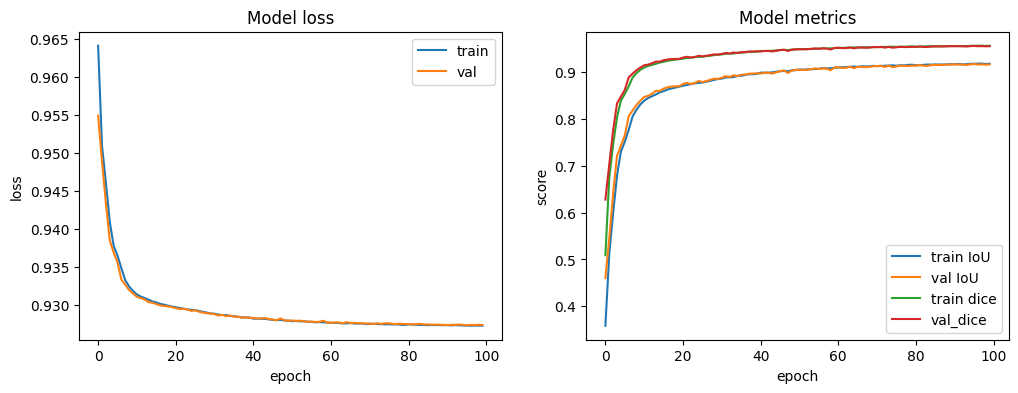

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

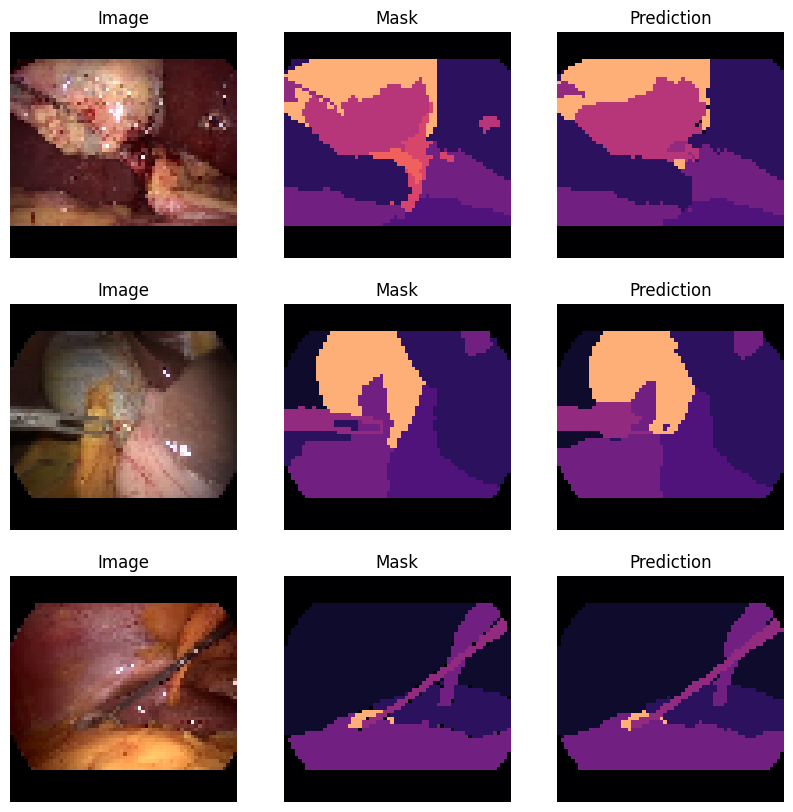

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota